<a href="https://colab.research.google.com/github/alexxten/PlatesClassification/blob/master/Plates_clf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!unzip plates.zip

In [0]:
#!rm /content/__MACOSX -rf

In [0]:
#!rm -rf /content/train /content/val

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

In [5]:
data_root = '/content/plates'
print(os.listdir(data_root))

['train', '.DS_Store', 'test']


In [0]:
import shutil 
from tqdm import tqdm

train_dir = '/content/plates_tv/train'
val_dir = '/content/plates_tv/val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

In [7]:
for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 1 == 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 21/21 [00:00<00:00, 3666.50it/s]


In [0]:
from torchvision import transforms, models
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
   
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [0]:
data_dir = '/content/plates_tv'
image_dataset = datasets.ImageFolder('/content/plates_tv/train', data_transforms['train'])
                
dataloader = torch.utils.data.DataLoader(image_dataset, batch_size=4,
                                             shuffle=True, num_workers=4)
           
dataset_size = len(image_dataset)
class_names = image_dataset.classes

In [0]:
#dataset_size

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

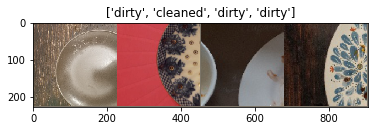

In [23]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  
    train_losses = []
    train_accs = []
   
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        
        is_train = True
        scheduler.step()
        model.train()  # Set model to training mode
        

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                loss.backward()
                optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_size
        epoch_acc = running_corrects.double() / dataset_size

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)

     
          
        # deep copy the model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, train_accs

In [0]:
def losses_accs_visualize(num_epochs, train_losses, train_accs):
  fig, ax = plt.subplots(figsize=(20, 10))
  x = np.arange(num_epochs)
  y0 = train_losses
  y1 = train_accs
  
  plt.subplot(321)
  plt.plot(x, y0)
  plt.title('train_losses')
  plt.grid(True)
  
  plt.subplot(322)
  plt.plot(x, y1)
  plt.title('train_accs')
  plt.grid(True)
  
  plt.show()
 

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [0]:
#Train model
model = models.resnet152(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

In [0]:
#model

In [0]:
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 1024)
model.activ = torch.nn.ReLU()
model.bn = torch.nn.BatchNorm1d(1024)
model.dropout = nn.Dropout(0.5)
model.fc1 = torch.nn.Linear(1024, 512)
model.activ1 = torch.nn.ReLU()
model.dropout1 = nn.Dropout(0.1)
model.fc2 = torch.nn.Linear(512, 20)
model.activ2 = torch.nn.ReLU()
model.fc3 = torch.nn.Linear(20, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [0]:
#model

In [40]:
device

device(type='cuda', index=0)

In [64]:
model, train_losses, train_accs = train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
Loss: 0.3734 Acc: 0.8500

Epoch 1/24
----------
Loss: 0.3409 Acc: 0.8750

Epoch 2/24
----------
Loss: 0.4377 Acc: 0.8500

Epoch 3/24
----------
Loss: 0.3340 Acc: 0.8750

Epoch 4/24
----------
Loss: 0.2861 Acc: 0.9000

Epoch 5/24
----------
Loss: 0.3839 Acc: 0.8500

Epoch 6/24
----------
Loss: 0.3386 Acc: 0.9250

Epoch 7/24
----------
Loss: 0.4280 Acc: 0.8500

Epoch 8/24
----------
Loss: 0.3373 Acc: 0.9250

Epoch 9/24
----------
Loss: 0.5653 Acc: 0.6250

Epoch 10/24
----------
Loss: 0.3148 Acc: 0.9250

Epoch 11/24
----------
Loss: 0.2669 Acc: 0.9500

Epoch 12/24
----------
Loss: 0.3284 Acc: 0.9500

Epoch 13/24
----------
Loss: 0.3920 Acc: 0.8000

Epoch 14/24
----------
Loss: 0.3643 Acc: 0.8500

Epoch 15/24
----------
Loss: 0.5001 Acc: 0.7250

Epoch 16/24
----------
Loss: 0.3230 Acc: 0.9250

Epoch 17/24
----------
Loss: 0.2958 Acc: 0.9000

Epoch 18/24
----------
Loss: 0.3866 Acc: 0.8000

Epoch 19/24
----------
Loss: 0.3166 Acc: 0.9000

Epoch 20/24
----------
Loss: 0

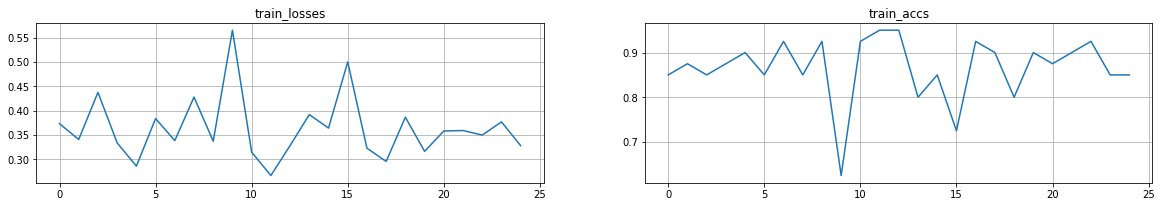

In [65]:
losses_accs_visualize(25, train_losses, train_accs)

In [0]:
!rm -rf test

In [66]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

In [0]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths(test_dir, data_transforms['val'])

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=8, shuffle=False, num_workers=4)

In [0]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in test_dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

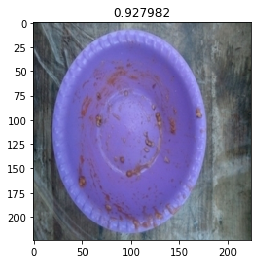

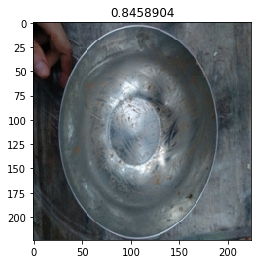

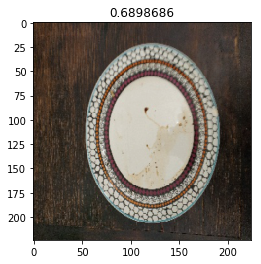

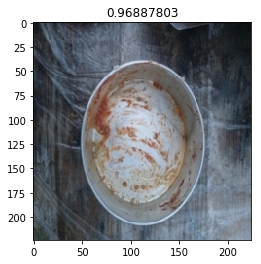

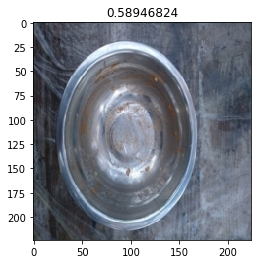

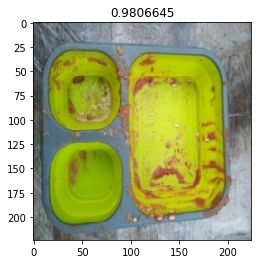

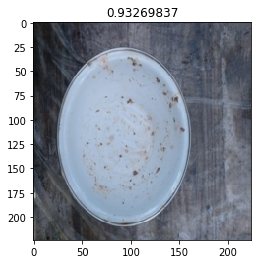

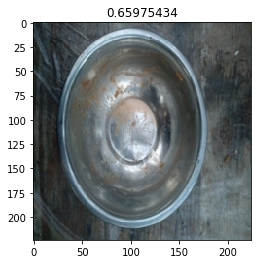

In [69]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    imshow(img, title=pred)

In [70]:
import pandas as pd
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

,label
id,
0000,dirty
0001,dirty
0002,dirty
0003,dirty
0004,dirty
0005,dirty


In [0]:
submission_df.to_csv('submission.csv')

In [0]:
#!rm /content/plates_tv test -rf